In [28]:
import pandas as pd
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.lines import Line2D

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

In [29]:
fields = (
    pd.read_csv('../data/supplementary/AllFields.csv', sep='\t',
                dtype={'Discipline':str, 'FieldOfStudyId':int})
    .rename(columns={'Discipline':'Field'})
)

In [30]:
%%time
authors = pd.read_csv('../data/figure_4/AuthorGenderCount.csv',sep='\t',usecols=['gender','Year','Field','Count'],
                      dtype={'gender':str,'Year':int,'Field':str,'Count':int})
print(authors.shape)

editors = pd.read_csv('../data/figure_4/EditorGenderCount.csv',sep='\t',usecols=['gender','Year','Field','Count'],
                      dtype={'gender':str,'Year':int,'Field':str,'Count':int})
print(editors.shape)

eic = pd.read_csv('../data/figure_4/ChiefGenderCount.csv',sep='\t',usecols=['gender','Year','Field','Count'],
                      dtype={'gender':str,'Year':int,'Field':str,'Count':int})
print(eic.shape)

(8127, 4)
(1751, 4)
(1013, 4)
CPU times: user 7.3 ms, sys: 3.07 ms, total: 10.4 ms
Wall time: 9.97 ms


In [31]:
authors = authors.merge(fields, on='Field')
editors = editors.merge(fields, on='Field')
eic = eic.merge(fields, on='Field')

In [33]:
dfs = [authors, editors, eic]

### Excluding Biology
#### Supplementary figure 8

In [32]:
def calcCI(p, n):
    p=p/100
    return np.sqrt(p*(1-p)/n)*scipy.stats.t.ppf((1+0.95)/2., n-1)

def computeTrend(fr, field=None, col='Year', colMin=1970, colMax=2018):
    # col: the column to get percentage; could be Year, or Decade etc.
    
    if field is not None:
        fr = fr[fr.Field == field]
    
    total = fr.groupby(col).Count.sum().reset_index()
    female = fr.groupby([col, 'gender']).Count.sum().reset_index().rename(columns={'Count':'Fcount'})
    female = female[female.gender == 'female']
    
    total = total.merge(female, on=col, how='left')
    total = total.assign(Percent = total.Fcount/total.Count*100)
    
    df = pd.DataFrame({col: [x for x in range(colMin, colMax+1)]})    
    df = df.merge(total, on=col, how='left').fillna(0).sort_values(by=col)
    
    return (df[col].values, df.Percent.values, df.Count.values)

def plotTrend(ax, x, y, n, color='green', lw=1):
    ax.plot(x, y, color=color, lw=lw)
    
    ci = [calcCI(y[i], n[i])*100 for i in range(len(x))]
    lo = [y[i]-ci[i] for i in range(len(x))]
    hi = [y[i]+ci[i] for i in range(len(x))]
    
    ax.fill_between(x, lo, hi, color=color, alpha=0.1)
    
def plotTemporal(ax, xy, lw=1):
    # xy: [(x, p, n)]
    
    plotTrend(ax, xy[0][0], xy[0][1], xy[0][2], colors[0], lw)
    plotTrend(ax, xy[1][0], xy[1][1], xy[1][2], colors[1], lw)
    plotTrend(ax, xy[2][0], xy[2][1], xy[2][2], colors[2], lw)
    
    ax.set_xlim(1970, 2018)
    ax.set_ylim(0, 1)
    
    ax.set_xticks([1970, 1980, 1990, 2000, 2010])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.grid(b=True, ls=':')
    ax.tick_params(length=0)

In [34]:
%%time
bio = [computeTrend(df.query('FieldOfStudyId == 86803240')) for df in dfs]
nobio = [computeTrend(df.query('FieldOfStudyId != 86803240')) for df in dfs]
maintrend = [computeTrend(df) for df in dfs]

CPU times: user 99.6 ms, sys: 0 ns, total: 99.6 ms
Wall time: 99.4 ms


In [36]:
colors = ['#4daf4a', '#377eb8', '#ff7f00']

CPU times: user 255 ms, sys: 10.8 ms, total: 266 ms
Wall time: 280 ms


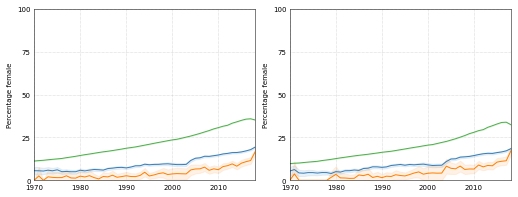

In [37]:
%%time
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 7*cm))
plt.rcParams.update({'font.size': 7})

lines = [Line2D([0], [0], color=colors[0], lw=1),
        Line2D([0], [0], color=colors[1], lw=1),
        Line2D([0], [0], color=colors[2], lw=1)]

#######
ax = plt.subplot(1, 2, 1)
plotTemporal(ax, maintrend)
ax.set_ylabel('Percentage female')

ax = plt.subplot(1, 2, 2)
plotTemporal(ax, nobio)
ax.set_ylabel('Percentage female')

plt.tight_layout()

plt.savefig('../figures/sup_4_gender_trend_bio_nobio.pdf', bbox_inches = 'tight', pad_inches = 0)

Other supplementary figures see notebook `figure_2/1.plot_figure_2.ipynb`.